## A segunda operação de uma CNN, o Pooling

As CNNs intercalam transformação e **subamostragem**.

- **Transformação**: Convolução;
- **Subamostragem**: Pooling.

A subamostragem é um subconjunto representativo do dado original. Podemos reduzir os pixels da imagem preservando suas características.

- Reduz a computação necessária para processar o dado;
- Menos parâmetros necessários para reproduzir características representativas da imagem;
- Menos chance de overfitting. "Não precisamos saber se alguém está de óculos para dizer se é uma pessoa ou um cachorro".

A cada iteração das camadas, o pooling vai extraindo subamostras da imagem com as características interessantes para se chegar a um resultado. Se nossa rede quer identificar se um objeto é uma pessoa, as características de pessoa são cada vez mais evidenciadas ao decorrer das camadas.

## MaxPool2d

Parâmetros:

- **Field of View**: Tamanho do pool (NxN);
- **Stride**: Tamanho do passo.

        Exemplo

        Imagem: 4x4

        |-----------------------|
        |  1  |  1  |  2  |  4  |
        |-----------------------|
        |  5  |  6  |  7  |  8  |
        |-----------------------|
        |  3  |  2  |  1  |  0  |
        |-----------------------|
        |  1  |  2  |  3  |  4  |
        |-----------------------|

        Pool: 2x2. O pool irá se sobrepor aos pixels da 
              imagem e extrair o pixel mais significativo
              do quadrante (MaxPool):

        Q1 -> 6
        Q2 -> 8
        Q3 -> 3
        Q4 -> 4

        Resultado:

        |-----------|
        |  6  |  8  |
        |-----------|
        |  3  |  4  |
        |-----------|

In [14]:
import torch
import matplotlib.pyplot as plt
from torch import nn

from skimage import data

In [3]:
dado = torch.FloatTensor([ [ [1, 2, 3],
                             [4, 5, 6],
                             [7, 8, 9] ] ])

pool = nn.MaxPool2d(kernel_size=2, stride=1)

saida = pool(dado)

print("Dimensionalidade dado:", dado.size())
print(dado)
print("Dimensionalidade saida:", saida.size())
print(saida)

Dimensionalidade dado: torch.Size([1, 3, 3])
tensor([[[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]])
Dimensionalidade saida: torch.Size([1, 2, 2])
tensor([[[5., 6.],
         [8., 9.]]])


Como podemos ver no tensor saida, o pool selecionou os maiores valores de cada janela. Com stride=1, temos sobreposição de janelas, por isso conseguimos operar todos os valores do dado.

Ao processar dados com múltiplos canais, a camada de pooling processa cada canal de entrada separadamente ao invés de processar todos os canais como em uma camada convolucional. Isso siginifica que o **número de canais de saída para a camada de pooling é o mesmo que o número de canais de entrada**.

Vamos ver isso com uma imagem RGB:

In [9]:
## Camada de Convolução

conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)

rgb = data.astronaut()
rgb_tns = torch.Tensor(rgb)

rgb_tns = rgb_tns.permute(2, 0, 1) # canal de cores primeiro
rgb_tns = rgb_tns.view(1, rgb_tns.size(0), rgb_tns.size(1), rgb_tns.size(2)) # adiciona a dimensao do batch na primeira posicao

rgb_tns.size()

torch.Size([1, 3, 512, 512])

In [10]:
mapa_de_ativacao = conv(rgb_tns)
print("Dimensionalidade do mapa de ativação:", mapa_de_ativacao.shape)

Dimensionalidade do mapa de ativação: torch.Size([1, 16, 512, 512])


In [45]:
## Camada de Pooling

pool = nn.MaxPool2d(kernel_size=2) # o stride padrão é do tamanho do kernel

saida = pool(mapa_de_ativacao)

print("Dimensionalidade após o Pooling:", saida.size())

Dimensionalidade após o Pooling: torch.Size([1, 16, 256, 256])


Como podemos ver, após o pooling nosso dado tem metade da dimensionalidade original, porém mantendo as características mais importantes.

Plot dos 16 mapas de características **ANTES** do Pooling:

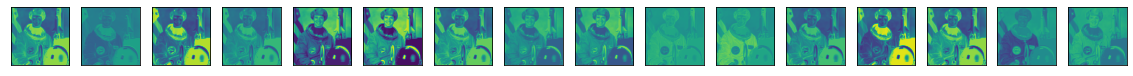

In [37]:
fig, axs = plt.subplots(1, saida.size(1), figsize=(20,15))
for k, ax in enumerate(axs):
    ax.imshow(mapa_de_ativacao[0,k,:,:].detach().numpy())
    ax.set_yticks([])
    ax.set_xticks([])

Plot dos 16 mapas de características **DEPOIS** do Pooling: 

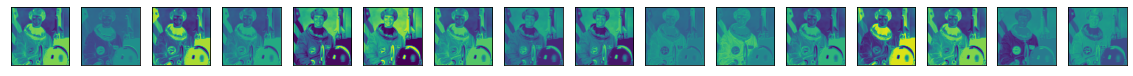

In [46]:
fig, axs = plt.subplots(1, saida.size(1), figsize=(20,20))
for k, ax in enumerate(axs):
    ax.imshow(saida[0,k,:,:].detach().numpy())
    ax.set_yticks([])
    ax.set_xticks([])

Zoom no primeiro mapa: Antes e depois do Pooling

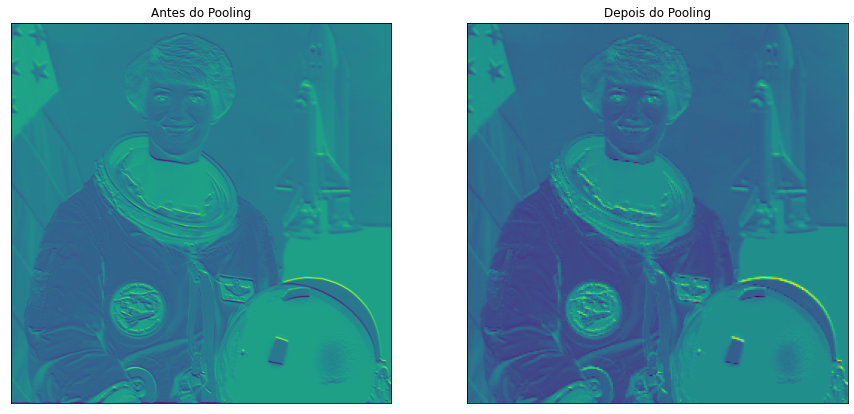

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(15,10))
for k, ax in enumerate(axs):
    if k==0:
        ax.imshow(mapa_de_ativacao[0,1,:,:].detach().numpy())
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title("Antes do Pooling")
    else:
        ax.imshow(saida[0,1,:,:].detach().numpy())
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title("Depois do Pooling")

Esse processo permite reduzir a resolução da imagem mantendo suas características importantes, ou seja, sem perder informação. Com isso temos um grande ganho de processamento.

"O papel do Pooling é subamostrar o mapa de ativação produzido pela convolução, a partir de um processo que destaca as principais características daquele mapa. A redução das dimensões espaciais é definida de acordo com o campo de visão e o stride do Pooling. Por exemplo, a camada nn.MaxPool2d(kernel_size=2, stride=2) reduzirá as dimensões espaciais pela metade, pois cada janela 2 x 2 da entrada será resumida em um único valor."

## Para saber mais



Enumeramos em aula algumas vantagens da subamostragem em redes convolucionais. Em termos de custo computacional, reduzir a dimensionalidade espacial dos mapas de ativação permite uma grande economia de processamento. Por si só essa já é uma vantagem bastante convincente para usar o pooling, pois imagens são dados de altíssima dimensionalidade.

Um dos principais livros de Deep Learning [1] define o Pooling como um "resumo estatístico" das saídas de uma convolução. Isso porque a camada não realiza uma subamostragem aleatória dos mapas de ativação, mas destaca as características mais relevantes de cada vizinhança local (definida pelo campo de visão do pooling).

Um importante efeito disso é que o Pooling torna a representação aproximadamente invariante a pequenas translações. Em termos claros, se a imagem de entrada for levemente deslocada no espaço, uma boa parte do mapa de características resultante do pooling não será alterado.

Os mapas de ativação produzidos pela convolução mantêm a informação espacial da entrada, ou seja, a localização das características ativadas está fortemente relacionada à localização das regiões correspondentes. Uma imagem espacialmente deslocada terá como saída um mapa de ativação espacialmente deslocado. Com o Pooling e o seu resumo estatístico, a rede concentra seus esforços em identificar a presença de características relevantes, independentes da sua localização específica na imagem.

Vale ressaltar que a informação espacial da imagem ainda é mantida até certo nível. O exemplo dado pelo livro menciona o problema de detecção de faces. Não importa a localização precisa dos olhos, mas importa bastante saber que existe um olho do lado esquerdo da face e outro do lado direito. O Pooling preserva esse nível de informação, que para a maioria dos problemas não só é suficiente, como também é vantajoso pela adição da invariância.

[1] Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. Deep learning. MIT press, 2016, pg 342.
